In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


# 1 Data

## 1.1 Create Time Series Data

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [ ]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

In [ ]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

## 1.2 Split Data

In [ ]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

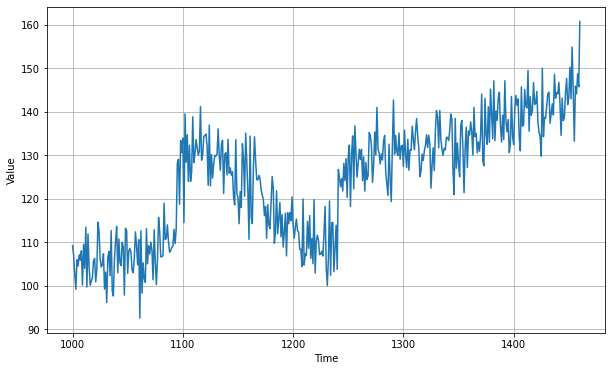

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


## 1.3 Windowed Dataset

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


# 2 Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


# 3 Forecast

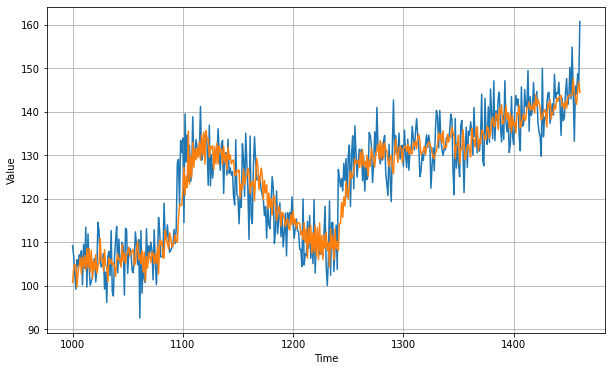

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# 4 Metric: MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7239256

# Another with Learning Rate Scheduler

## *1.3 Windowed Dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# *2 Model

## 2.1 Pick Learning Rate

### 2.1.1 Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

### 2.2 View per epoch Learning Rates vs Loss

(1e-08, 0.001, 0.0, 300.0)

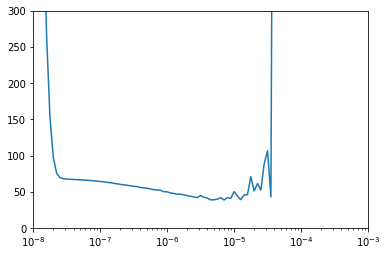

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

### 2.3 Get Learning Rate with Minimum Loss

In [ ]:
index_minloss = np.argmin(history.history["loss"]) # get index of the min loss

In [ ]:
np.argmin(history.history["loss"])

57

In [ ]:
lrs[index_minloss]

7.079457843841381e-06

## 2.2 Use chosen learning rate with minimum loss for final model

In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

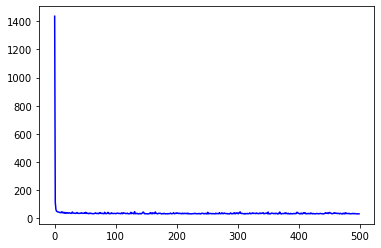

In [ ]:
# view all loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[41.187705993652344, 46.74949645996094, 40.36345672607422, 45.36448287963867, 40.38520050048828, 42.23564529418945, 37.80087661743164, 42.89316940307617, 37.80179977416992, 37.538394927978516, 41.67294692993164, 40.33934020996094, 36.91788101196289, 39.17306137084961, 40.364967346191406, 38.1783561706543, 37.03086471557617, 35.786285400390625, 38.66024398803711, 46.02388000488281, 38.7245979309082, 37.39775848388672, 37.90586853027344, 36.82988739013672, 35.536468505859375, 36.64323425292969, 40.65007400512695, 41.831016540527344, 36.106956481933594, 35.888092041015625, 36.232887268066406, 36.479644775390625, 37.64631652832031, 36.63650131225586, 40.14740753173828, 37.715843200683594, 36.16044998168945, 36.83964920043945, 36.4515495300293, 39.89314651489258, 36.04325866699219, 43.76519775390625, 36.17656707763672, 36.594383239746094, 37.950279235839844, 34.426509857177734, 34.44369125366211, 37.6512565612793, 34.90087127685547, 37.243125915527344, 36.07313537597656, 34.23698806762695, 

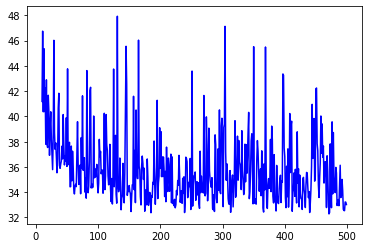

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

# *3 Forecast

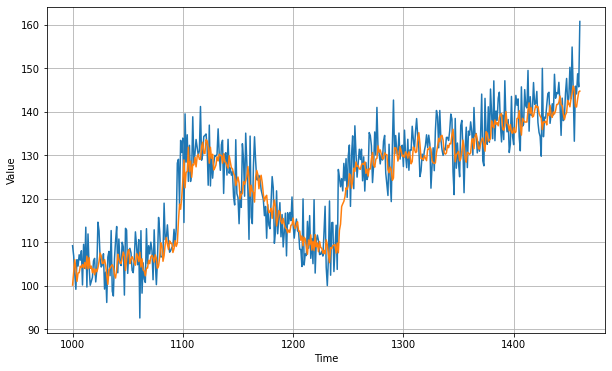

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# *4 Metric: MAE

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6042466